# Tarea de Clasificación Multiclase
## - Clasificación de Cardiopatías en base a Electrocardiogramas (ECGs)

Este conjunto de datos se compone de dos colecciones de señales de latido derivadas de dos conjuntos de datos famosos en la clasificación de latidos, el conjunto de datos de arritmias [KAGGLE](https://www.kaggle.com/shayanfazeli/heartbeat). La cantidad de muestras en ambas colecciones es lo suficientemente grande para entrenar una red neuronal profunda.

Este conjunto de datos se ha utilizado para explorar la clasificación de latidos utilizando arquitecturas de redes neuronales profundas y observar algunas de las capacidades de transferencia de aprendizaje en él.

Las señales corresponden a formas de latidos cardíacos de electrocardiograma (ECG) para el caso normal y los casos afectados por diferentes arritmias e infarto de miocardio. Estas señales se preprocesan y segmentan, y cada segmento corresponde a un latido.

In [4]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c9/46/6cbaf20f5bd0e7c1d204b45b853c2cd317b303fada90245f2825ecca47de/matplotlib-3.7.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a5/d6/80258c2759bd34abe267b5d3bc6300f7105aa70181b99d531283f7e7c79e/contourpy-1.1.0-cp39-cp39-win_amd64.whl.metadata
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/1b/6d/93121de94919bd072a93131167d7c6244eb26fe9f2f897ddfee8eb550ffa/fonttools-4.42.1-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/154.1 kB ? eta -:--:--
     ----------------------------------- -- 143.4/154.1 kB 2.8 MB/s eta 0:00:01
     -------------------------------------- 154.1/154.1 kB 2.3 MB/s eta 0:00:00
  Obtaining dependency information for kiwisolver>=1.0.1 from ht

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Training verbosity
VERBOSE = 1

# Google Colab
COLAB = False

# TB callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {'mitbih': 'logs/mitbih/tb_'}
TBLOGDIRS = {k:v+current_time for (k,v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS['mitbih'], histogram_freq = 1)

## Carga de datos

In [3]:
data_train = pd.read_csv('mitbih_train.csv')
data_test = pd.read_csv('mitbih_test.csv')

In [4]:
#data_train = pd.read_parquet('mitbih_train.parquet')
#data_test = pd.read_parquet('mitbih_test.parquet')

In [5]:
#data_train.head()

In [6]:
#data_test.tail()

In [7]:
X_train = data_train.iloc[:,:187]
X_test = data_test.iloc[:, :187]

In [8]:
Y_train = data_train.iloc[:,187]
Y_test = data_test.iloc[:,187]

In [9]:
classes = np.unique(Y_train)
nclasses = len(classes)

In [10]:
list(classes)

[0.0, 1.0, 2.0, 3.0, 4.0]

## Pequeño analisis exploratorio de la distribución de las clases

(array([0.82772721, 0.02539033, 0.06610853, 0.00732128, 0.07345265]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

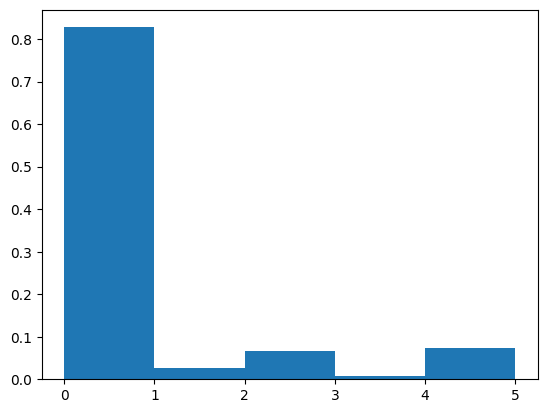

In [11]:
plt.hist(Y_train, bins=np.arange(Y_train.min(), Y_train.max()+2), density = True)

In [12]:
print(Y_train.value_counts())

0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


## One-Hot Encoding con Keras

In [13]:
Y_train = keras.utils.to_categorical(Y_train, nclasses)
Y_test = keras.utils.to_categorical(Y_test, nclasses)

In [14]:
Y_train[:2]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [15]:
Y_train.shape

(87553, 5)

In [16]:
Y_test.shape

(21891, 5)

## Partición de Train dataset en Train (SubTrain) y Validation datasets

In [17]:
X_train, X_val, Y_train , Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1)

## Construcción de red neuronal con arquitectura feedforward sencilla (2 capas)

In [18]:
input_dim = X_train.shape[1]

In [19]:
input_dim

187

In [20]:
model = Sequential()
model.add(Dense(64, input_shape = (input_dim,), activation='relu'))
model.add(Dense(nclasses, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12032     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 12357 (48.27 KB)
Trainable params: 12357 (48.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


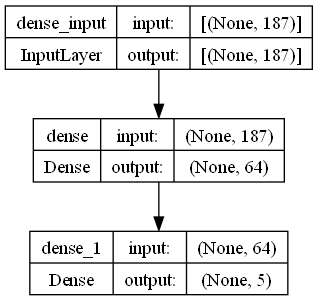

In [22]:
keras.utils.plot_model(model, show_shapes= True)

## Definición de:
- ### Hiperparametros de entrenamiento (Learning Rate, Loss Function, Optimizer, Batch Size, Epochs)
- ### Métrica objetivo (accuracy?)

In [23]:
learn_rate = .001
opt = Adam(learning_rate= learn_rate)

In [24]:
model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
batch_size = 10
epochs = 10

## Entrenamiento

In [26]:
training_history = model.fit(X_train,Y_train,
                            validation_data = (X_val,Y_val),
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = TensorBoard(TBLOGDIRS['mitbih'], histogram_freq=1),
                            verbose = VERBOSE)

Epoch 1/10


7005/7005 [==============================] - 18s 2ms/step - loss: 0.2730 - accuracy: 0.9249 - val_loss: 0.1954 - val_accuracy: 0.9439
Epoch 2/10
7005/7005 [==============================] - 15s 2ms/step - loss: 0.1768 - accuracy: 0.9531 - val_loss: 0.1803 - val_accuracy: 0.9506
Epoch 3/10
7005/7005 [==============================] - 17s 2ms/step - loss: 0.1498 - accuracy: 0.9591 - val_loss: 0.1460 - val_accuracy: 0.9599
Epoch 4/10
7005/7005 [==============================] - 16s 2ms/step - loss: 0.1354 - accuracy: 0.9625 - val_loss: 0.1459 - val_accuracy: 0.9603
Epoch 5/10
7005/7005 [==============================] - 17s 2ms/step - loss: 0.1255 - accuracy: 0.9644 - val_loss: 0.1293 - val_accuracy: 0.9639
Epoch 6/10
7005/7005 [==============================] - 15s 2ms/step - loss: 0.1180 - accuracy: 0.9664 - val_loss: 0.1260 - val_accuracy: 0.9657
Epoch 7/10
7005/7005 [==============================] - 15s 2ms/step - loss: 0.1125 - accuracy: 0.9683 - val_loss: 0.1170 - val_accuracy: 0.9

In [27]:
y_pseudo_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pseudo_probabilities, axis = 1)
y_test = np.argmax(Y_test, axis = 1)

685/685 [==============================] - 1s 2ms/step


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18117
           1       0.79      0.66      0.72       556
           2       0.90      0.90      0.90      1448
           3       0.77      0.48      0.59       162
           4       0.99      0.94      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.79      0.83     21891
weighted avg       0.97      0.97      0.97     21891



## Evaluacion del modelo

In [29]:
# %pip install seaborn

In [30]:
from utils import eval_model

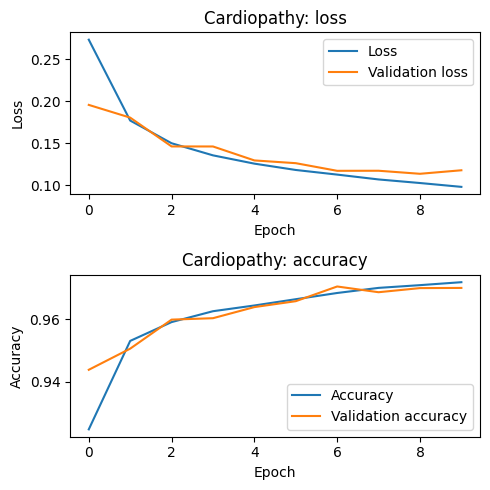

685/685 [==============================] - 1s 2ms/step


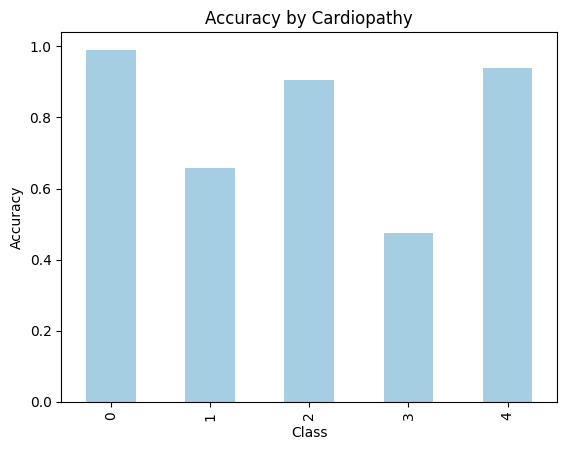

Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18117
           1       0.79      0.66      0.72       556
           2       0.90      0.90      0.90      1448
           3       0.77      0.48      0.59       162
           4       0.99      0.94      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.79      0.83     21891
weighted avg       0.97      0.97      0.97     21891

Confusion matrix
[[17937    84    71     9    16]
 [  177   365    12     0     2]
 [  112     9  1310    14     3]
 [   54     0    31    77     0]
 [   70     3    24     0  1511]]


Loss function: 0.12250351160764694, accuracy: 0.9684345126152039


In [31]:
eval_model(training_history, model, X_test, Y_test, 'Cardiopathy')

# Tarea

### Ejercicio 1. Implemente y evalue una red de 3 capas utilizando la técnica de regularización dropout

In [32]:
model2 = Sequential()
model2.add(Dense(64, input_shape = (input_dim,), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(nclasses, activation='sigmoid'))

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                12032     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 20997 (82.02 KB)
Trainable params: 20997 (82.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
learn_rate = .001
opt = Adam(learning_rate= learn_rate)

model2.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [62]:
batch_size = 10
epochs = 10

training_history = model2.fit(X_train,Y_train,
                            validation_data = (X_val,Y_val),
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = TensorBoard(TBLOGDIRS['mitbih'], histogram_freq=1),
                            verbose = VERBOSE)

Epoch 1/10
7005/7005 [==============================] - 21s 3ms/step - loss: 0.3670 - accuracy: 0.8999 - val_loss: 0.2309 - val_accuracy: 0.9298
Epoch 2/10
7005/7005 [==============================] - 19s 3ms/step - loss: 0.2726 - accuracy: 0.9234 - val_loss: 0.1961 - val_accuracy: 0.9406
Epoch 3/10
7005/7005 [==============================] - 20s 3ms/step - loss: 0.2480 - accuracy: 0.9313 - val_loss: 0.1726 - val_accuracy: 0.9519
Epoch 4/10
7005/7005 [==============================] - 20s 3ms/step - loss: 0.2314 - accuracy: 0.9356 - val_loss: 0.1752 - val_accuracy: 0.9485
Epoch 5/10
7005/7005 [==============================] - 23s 3ms/step - loss: 0.2231 - accuracy: 0.9380 - val_loss: 0.1627 - val_accuracy: 0.9522
Epoch 6/10
7005/7005 [==============================] - 26s 4ms/step - loss: 0.2186 - accuracy: 0.9391 - val_loss: 0.1740 - val_accuracy: 0.9451
Epoch 7/10
7005/7005 [==============================] - 19s 3ms/step - loss: 0.2154 - accuracy: 0.9403 - val_loss: 0.1586 - val_ac

In [35]:
y_pseudo_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pseudo_probabilities, axis = 1)
y_test = np.argmax(Y_test, axis = 1)

 31/685 [>.............................] - ETA: 1s 

685/685 [==============================] - 1s 2ms/step


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18117
           1       0.79      0.66      0.72       556
           2       0.90      0.90      0.90      1448
           3       0.77      0.48      0.59       162
           4       0.99      0.94      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.79      0.83     21891
weighted avg       0.97      0.97      0.97     21891



In [37]:
from utils import eval_model

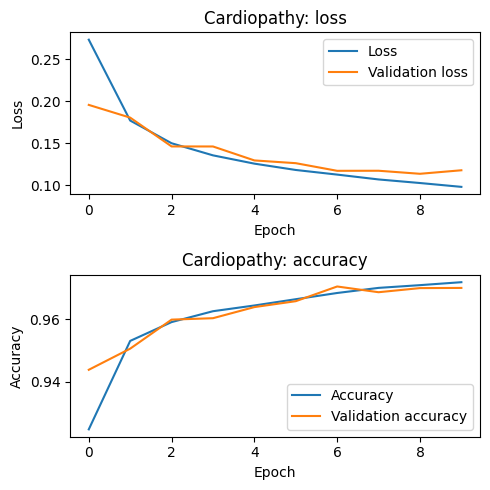

685/685 [==============================] - 1s 1ms/step


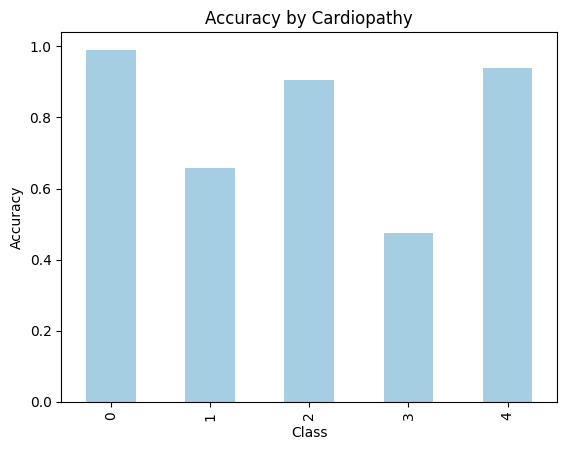

Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18117
           1       0.79      0.66      0.72       556
           2       0.90      0.90      0.90      1448
           3       0.77      0.48      0.59       162
           4       0.99      0.94      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.79      0.83     21891
weighted avg       0.97      0.97      0.97     21891

Confusion matrix
[[17937    84    71     9    16]
 [  177   365    12     0     2]
 [  112     9  1310    14     3]
 [   54     0    31    77     0]
 [   70     3    24     0  1511]]


Loss function: 0.12250351160764694, accuracy: 0.9684345126152039


In [38]:
eval_model(training_history, model, X_test, Y_test, 'Cardiopathy')

### Ejercicio 2. Implemente y evalue una red de 6 capas utilizando la técnica de regularización Early Stopping de 1 Fase

In [39]:
model3 = Sequential()
model3.add(Dense(64, input_shape = (input_dim,), activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1024, activation='relu'))
model3.add(Dense(nclasses, activation='softmax'))

learn_rate = .001
opt = Adam(learning_rate= learn_rate)

callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model3.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

training_history = model3.fit(X_train,Y_train,
                            validation_data = (X_val,Y_val),
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = [callback_early_stopping,TensorBoard(TBLOGDIRS['mitbih'], histogram_freq=1)],
                            verbose = VERBOSE)

Epoch 1/10
7005/7005 [==============================] - 96s 13ms/step - loss: 0.2351 - accuracy: 0.9377 - val_loss: 0.1692 - val_accuracy: 0.9561
Epoch 2/10
7005/7005 [==============================] - 88s 13ms/step - loss: 0.1610 - accuracy: 0.9559 - val_loss: 0.1705 - val_accuracy: 0.9563
Epoch 3/10
7005/7005 [==============================] - 79s 11ms/step - loss: 0.1362 - accuracy: 0.9633 - val_loss: 0.1309 - val_accuracy: 0.9642
Epoch 4/10
7005/7005 [==============================] - 93s 13ms/step - loss: 0.1212 - accuracy: 0.9666 - val_loss: 0.1438 - val_accuracy: 0.9609
Epoch 5/10
7005/7005 [==============================] - 90s 13ms/step - loss: 0.1124 - accuracy: 0.9692 - val_loss: 0.1551 - val_accuracy: 0.9613
Epoch 6/10
7005/7005 [==============================] - 74s 11ms/step - loss: 0.1077 - accuracy: 0.9695 - val_loss: 0.1453 - val_accuracy: 0.9674
Epoch 7/10
7005/7005 [==============================] - 83s 12ms/step - loss: 0.1049 - accuracy: 0.9707 - val_loss: 0.1919 -

In [40]:
%load_ext tensorboard

### Ejercicio 3. Pongase creativo e implemente y evalue una red neuronal a gusto, que utilice al menos 2 técnicas vistas en el teórico

In [ ]:
# SU CÓDIGO AQUI

### Ejercicio 4. Desarrolle en lenguaje natural, un texto describiendo las arquitecturas utilizadas, cual considera que dio mejor resultado y porque.

#### Su texto aqui